In [47]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 
import pickle


import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import scipy
from scipy import interpolate
from scipy.stats import binned_statistic_2d
from scipy.ndimage.filters import gaussian_filter
from astropy.table import Table, Column, vstack, join

import palettable

cmap_1 = palettable.colorbrewer.sequential.Blues_7_r
cmap_2 = palettable.colorbrewer.sequential.OrRd_7_r
cmap_3 = palettable.colorbrewer.sequential.YlGn_7_r
cmap_4 = palettable.colorbrewer.sequential.Purples_7_r

cmap_list = [cmap_1, cmap_2, cmap_3, cmap_4]

color_bins = ["#377eb8", "#e41a1c", "#1b9e77", "#984ea3"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import jianbing

from jianbing import hsc
from jianbing import utils
from jianbing import visual
from jianbing import catalog

In [3]:
data_dir = jianbing.DATA_DIR

fig_dir = jianbing.FIG_DIR

sim_dir = jianbing.SIM_DIR
bin_dir = jianbing.BIN_DIR
res_dir = jianbing.RES_DIR

In [4]:
def dsigma_inn_out_compare(dsigma, error='jk', r_1=0.2, r_2=0.8, r_3=3.0, use_mod_err=True, verbose=True):
    """
    Explore the ratio or difference between the inner and outer part of
    a DSigma g-g lensing profile.
    """
    dsig_obs = dsigma['dsigma']
    dsig_obs_err = dsigma['dsig_err_{:s}'.format(error)]
    dsig_obs_upp = dsig_obs - dsig_obs_err

    dsig_mod = dsigma['dsigma_mod_{:s}'.format(error)]
    dsig_mod_upp = dsigma['dsigma_mod_upp_{:s}'.format(error)]
    dsig_mod_low = dsigma['dsigma_mod_low_{:s}'.format(error)]
                          
    r_mpc = dsigma.meta['r_mpc']

    mask_inn = (r_mpc >= r_1) & (r_mpc < r_2)
    mask_out = (r_mpc >= r_2) & (r_mpc < r_3)
    
    if mask_inn.sum() < 2:
        raise ValueError('R1, R2 range is too small!')
    if mask_out.sum() < 2:
        raise ValueError('R2, R3 range is too small!')
        
    # Ratio
    obs_inn = np.trapz(dsig_obs[mask_inn], x=r_mpc[mask_inn])  
    obs_out = np.trapz(dsig_obs[mask_out], x=r_mpc[mask_out])  
    
    obs_inn_upp = np.trapz(dsig_obs_upp[mask_inn], x=r_mpc[mask_inn])
    obs_out_upp = np.trapz(dsig_obs_upp[mask_out], x=r_mpc[mask_out])

    obs_ratio = obs_out / obs_inn
    obs_ratio_err = (np.hypot((obs_out_upp - obs_out) / obs_out, (obs_inn_upp - obs_inn) / obs_inn) * np.abs(obs_out / obs_inn))

    mod_inn = np.trapz(dsig_mod[mask_inn], x=r_mpc[mask_inn])
    mod_out = np.trapz(dsig_mod[mask_out], x=r_mpc[mask_out])
    if use_mod_err:
        mod_inn_upp = np.trapz(dsig_mod_upp[mask_inn], x=r_mpc[mask_inn])
        mod_out_upp = np.trapz(dsig_mod_upp[mask_out], x=r_mpc[mask_out])
    else:
        mod_inn_upp = mod_inn
        mod_out_upp = mod_out

    mod_ratio = mod_out / mod_inn
    mod_ratio_err = np.hypot(
        (mod_out_upp - mod_out) / mod_out, (mod_inn_upp - mod_inn) / mod_inn) * np.abs(mod_out / mod_inn)
        
    obs_mod_ratio = obs_ratio / mod_ratio
    obs_mod_ratio_err = np.hypot((obs_ratio_err / obs_ratio), (mod_ratio_err / mod_ratio)) * np.abs(obs_mod_ratio)

    if verbose:
        print("(ds_out / ds_inn)_obs / (ds_out / ds_inn)_mod: {:6.3f} +/- {:6.3f}".format(obs_mod_ratio, obs_mod_ratio_err))
        
    # Difference
    diff_inn = np.trapz(dsig_obs[mask_inn] - dsig_mod[mask_inn], x=r_mpc[mask_inn])
    diff_out = np.trapz(dsig_obs[mask_out] - dsig_mod[mask_out], x=r_mpc[mask_out])

    if use_mod_err:
        diff_inn_upp = np.trapz(dsig_obs_upp[mask_inn] - dsig_mod_low[mask_inn], x=r_mpc[mask_inn])
        diff_out_upp = np.trapz(dsig_obs_upp[mask_out] - dsig_mod_low[mask_out], x=r_mpc[mask_out])
    else:
        diff_inn_upp = np.trapz(dsig_obs_upp[mask_inn] - dsig_mod[mask_inn], x=r_mpc[mask_inn])
        diff_out_upp = np.trapz(dsig_obs_upp[mask_out] - dsig_mod[mask_out], x=r_mpc[mask_out])

    diff = (diff_out - diff_inn)
    diff_err = np.hypot((diff_out_upp - diff_out), (diff_inn_upp - diff_inn))
    
    if verbose:
        print("Diff_out - Diff_inn: {:6.3f} +/- {:6.3f}".format(diff, diff_err))
    
    return {
        "obs_inn": obs_inn, "obs_inn_upp": obs_inn_upp, 
        "obs_out": obs_out, "obs_out_upp": obs_out_upp, 
        "mod_inn": mod_inn, "mod_inn_upp": mod_inn_upp, 
        "mod_out": mod_out, "mod_out_upp": mod_out_upp, 
        "obs_ratio": obs_ratio, "obs_ratio_err": obs_ratio_err,
        "mod_ratio": mod_ratio, "mod_ratio_err": mod_ratio_err,
        "obs_mod_ratio": obs_mod_ratio, "obs_mod_ratio_err": obs_mod_ratio_err,
        "diff_inn": diff_inn, "diff_inn_upp": diff_inn_upp,
        "diff_out": diff_out, "diff_out_upp": diff_out_upp,
        "diff": diff, "diff_err": diff_err
    }

### Compare inner and outer part of the $\Delta\Sigma$ profiles
#### DSigma profiles of HSC massive galaxies

In [5]:
# DeltaSigma profiles of HSC massive galaxies
topn_massive = pickle.load(open(os.path.join(res_dir, 'topn_galaxies_sum.pkl'), 'rb'))

# DeltaSigma profiles of redMaPPer and CAMIRA clusters
topn_cluster = pickle.load(open(os.path.join(res_dir, 'topn_clusters_cen_sum.pkl'), 'rb'))

# For clusters, but using both central and satellite galaxies
topn_cluster_all = pickle.load(open(os.path.join(res_dir, 'topn_clusters_sum.pkl'), 'rb'))

#### DSigma profiles of mock galaxies

In [6]:
sim_dsig = Table.read(os.path.join(sim_dir, 'sim_merge_all_dsig.fits'))

In [9]:
_ = dsigma_inn_out_compare(topn_massive['logm_50_100'][0], error='jk', r_1=0.2, r_2=0.8, r_3=3.0, verbose=True)

(ds_out / ds_inn)_obs / (ds_out / ds_inn)_mod:  1.038 +/-  0.195
Diff_out - Diff_inn:  2.812 +/-  8.583


In [10]:
# redMaPPer
redm_1_diff = Table([dsigma_inn_out_compare(
    ds, error='jk', r_1=0.2, r_2=0.8, r_3=3.0, use_mod_err=False, verbose=True) for ds in topn_cluster['redm_hsc_lambda']])

redm_1_diff['bin'] = [1, 2, 3, 4]

(ds_out / ds_inn)_obs / (ds_out / ds_inn)_mod:  1.348 +/-  0.234
Diff_out - Diff_inn: 17.235 +/- 10.010
(ds_out / ds_inn)_obs / (ds_out / ds_inn)_mod:  1.413 +/-  0.209
Diff_out - Diff_inn: 11.874 +/-  4.794
(ds_out / ds_inn)_obs / (ds_out / ds_inn)_mod:  1.219 +/-  0.122
Diff_out - Diff_inn:  5.060 +/-  2.544
(ds_out / ds_inn)_obs / (ds_out / ds_inn)_mod:  1.081 +/-  0.154
Diff_out - Diff_inn:  1.113 +/-  2.014


In [11]:
# CAMIRA
cam_1_diff = Table([dsigma_inn_out_compare(
    ds, error='jk', r_1=0.2, r_2=0.8, r_3=3.0, use_mod_err=False, verbose=True) for ds in topn_cluster['cam_s16a_n_mem']])
cam_1_diff['bin'] = [1, 2, 3, 4]

(ds_out / ds_inn)_obs / (ds_out / ds_inn)_mod:  1.572 +/-  0.277
Diff_out - Diff_inn: 25.037 +/-  9.300
(ds_out / ds_inn)_obs / (ds_out / ds_inn)_mod:  1.520 +/-  0.224
Diff_out - Diff_inn: 13.654 +/-  4.542
(ds_out / ds_inn)_obs / (ds_out / ds_inn)_mod:  1.645 +/-  0.215
Diff_out - Diff_inn: 10.324 +/-  2.578
(ds_out / ds_inn)_obs / (ds_out / ds_inn)_mod:  2.221 +/-  0.687
Diff_out - Diff_inn: 11.811 +/-  4.344


In [12]:
mout_1_diff = Table([dsigma_inn_out_compare(
    ds, error='jk', r_1=0.2, r_2=0.8, r_3=3.0, use_mod_err=False, verbose=True) for ds in topn_massive['logm_50_100']])
mout_1_diff['bin'] = [1, 2, 3, 4]

(ds_out / ds_inn)_obs / (ds_out / ds_inn)_mod:  1.038 +/-  0.193
Diff_out - Diff_inn:  2.812 +/- 10.139
(ds_out / ds_inn)_obs / (ds_out / ds_inn)_mod:  1.062 +/-  0.170
Diff_out - Diff_inn:  1.832 +/-  5.250
(ds_out / ds_inn)_obs / (ds_out / ds_inn)_mod:  1.125 +/-  0.141
Diff_out - Diff_inn:  2.931 +/-  3.143
(ds_out / ds_inn)_obs / (ds_out / ds_inn)_mod:  1.015 +/-  0.121
Diff_out - Diff_inn:  0.283 +/-  2.194


### Define a $S$ statistics that compares the ratio of integrated lensing profiles in the outer and inner region

- $S \equiv \frac{\int_{0.8\ \mathrm{Mpc}}^{3.0\ \rm Mpc} \Delta\Sigma(r) d r}{\int_{0.2\ \mathrm{Mpc}}^{0.8\ \mathrm{Mpc}} \Delta\Sigma(r) d r}$'

- We first show the $S$ for the observed profiles.
- Then we compare the observed $S$ and the model ones

Text(0, 0.5, '$S_{\\rm obs} / S_{\\rm mod}$')

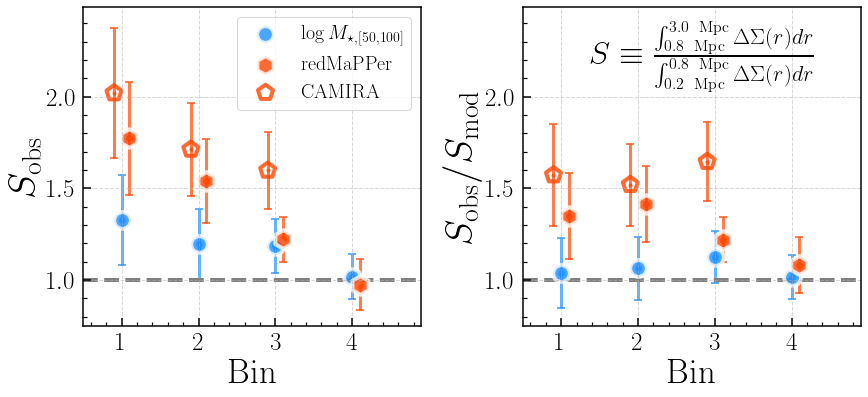

In [43]:
fig = plt.figure(figsize=(12, 5.4))

fig.subplots_adjust(
    left=0.09, bottom=0.16, right=0.99, top=0.98, wspace=0.3, hspace=0.1)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

equation = r'$S \equiv \frac{\int_{0.8\ \mathrm{Mpc}}^{3.0\ \rm Mpc} \Delta\Sigma(r) d r}{\int_{0.2\ \mathrm{Mpc}}^{0.8\ \mathrm{Mpc}} \Delta\Sigma(r) d r}$'

ax1.grid(True)

ax1.errorbar(mout_1_diff['bin'], mout_1_diff['obs_ratio'], yerr=mout_1_diff['obs_ratio_err'],
             ecolor='dodgerblue', color='dodgerblue', alpha=0.7,
             capsize=4, capthick=2.0, elinewidth=3.0, label='__no_label__',
             fmt='o', zorder=0)
ax1.scatter(mout_1_diff['bin'], mout_1_diff['obs_ratio'],
            s=280, alpha=0.8, facecolor='dodgerblue', edgecolor='w',
            linewidth=4.0, label=r'$\log M_{\star, [50, 100]}$')

ax1.errorbar(redm_1_diff['bin'] + 0.1, redm_1_diff['obs_ratio'], yerr=redm_1_diff['obs_ratio_err'],
             ecolor='orangered', color='orangered', alpha=0.7,
             capsize=4, capthick=2.0, elinewidth=3.0, label='__no_label__',
             fmt='o', zorder=0)
ax1.scatter(redm_1_diff['bin'] + 0.1, redm_1_diff['obs_ratio'], marker='h',
            s=350, alpha=0.8, facecolor='orangered', edgecolor='w',
            linewidth=4.0, label=r'$\rm redMaPPer$')

ax1.errorbar(cam_1_diff['bin'][0:3] - 0.1, cam_1_diff['obs_ratio'][0:3], yerr=cam_1_diff['obs_ratio_err'][0:3],
             ecolor='orangered', color='orangered', alpha=0.7,
             capsize=4, capthick=2.0, elinewidth=3.0, label='__no_label__',
             fmt='.', zorder=0)
ax1.scatter(cam_1_diff['bin'][0:3] - 0.1, cam_1_diff['obs_ratio'][0:3], marker='p',
            s=250, alpha=0.8, facecolor='none', edgecolor='orangered',
            linewidth=4.0, label=r'$\rm CAMIRA$')


ax1.set_ylim(0.75, 2.49)
ax1.set_xlim(0.5, 4.9)
ax1.set_xticks([1, 2, 3, 4])
ax1.set_yticks([1.0, 1.5, 2.0])

ax1.legend(loc='upper right', fontsize=20)
ax1.axhline(1.0, linewidth=4.0, linestyle='--', c='grey', zorder=0)

ax1.set_xlabel(r'$\rm Bin$', fontsize=35)
ax1.set_ylabel(r'$S_{\rm obs}$', fontsize=40)

# ----------------------------------------------------------------------------------------------- #
ax2.grid(True, linewidth=1.0, alpha=0.5)

ax2.errorbar(mout_1_diff['bin'], mout_1_diff['obs_mod_ratio'], yerr=mout_1_diff['obs_mod_ratio_err'],
            ecolor='dodgerblue', color='dodgerblue', alpha=0.7,
            capsize=4, capthick=2.0, elinewidth=3.0, label='__no_label__',
            fmt='o', zorder=0)
ax2.scatter(mout_1_diff['bin'], mout_1_diff['obs_mod_ratio'],
           s=280, alpha=0.8, facecolor='dodgerblue', edgecolor='w',
           linewidth=4.0, label=r'$\log M_{\star, [50, 100]}$')

ax2.errorbar(redm_1_diff['bin'] + 0.1, redm_1_diff['obs_mod_ratio'], yerr=redm_1_diff['obs_mod_ratio_err'],
            ecolor='orangered', color='orangered', alpha=0.7,
            capsize=4, capthick=2.0, elinewidth=3.0, label='__no_label__',
            fmt='o', zorder=0)
ax2.scatter(redm_1_diff['bin'] + 0.1, redm_1_diff['obs_mod_ratio'], marker='h',
           s=350, alpha=0.8, facecolor='orangered', edgecolor='w',
           linewidth=4.0, label=r'$\rm redMaPPer$')

ax2.errorbar(cam_1_diff['bin'][0:3] - 0.1, cam_1_diff['obs_mod_ratio'][0:3], yerr=cam_1_diff['obs_mod_ratio_err'][0:3],
            ecolor='orangered', color='orangered', alpha=0.7,
            capsize=4, capthick=2.0, elinewidth=3.0, label='__no_label__',
            fmt='.', zorder=0)
ax2.scatter(cam_1_diff['bin'][0:3] - 0.1, cam_1_diff['obs_mod_ratio'][0:3], marker='p',
           s=250, alpha=0.8, facecolor='none', edgecolor='orangered',
           linewidth=4.0, label=r'$\rm CAMIRA$')

ax2.text(0.2, 0.82, equation, fontsize=32, transform=ax2.transAxes)

ax2.set_ylim(0.75, 2.49)
ax2.set_xlim(0.5, 4.9)
ax2.set_xticks([1, 2, 3, 4])

ax2.axhline(1.0, linewidth=4.0, linestyle='--', c='grey', zorder=0)

ax2.set_xlabel(r'$\rm Bin$', fontsize=35)
ax2.set_ylabel(r'$S_{\rm obs} / S_{\rm mod}$', fontsize=40)

In [44]:
fig.savefig(os.path.join(fig_dir, 'fig_11.png'), dpi=120)
fig.savefig(os.path.join(fig_dir, 'fig_11.pdf'), dpi=120)

### Demonstrate the richness v.s. stellar mass comparison

In [45]:
def hmf_gen(norm):
    """Return a function that describes the exponentialy declining halo mass."""
    def hmf(params, pivot, mu):
        exponent = 0
        for i, p in enumerate(params):
            exponent -= p * (mu - pivot)**i / np.math.factorial(i)
        return np.exp(exponent) / norm
    return hmf

def draw_n_halo_mass(n_halo, hmf_use, halo_mass_bins):
    """Randomly draw N halo mass from a given halo mass function
    
    - Cumulatively integrate the HMF to get the "curve-of-growth" ranging between 0 and 1.
    - Then create an interpolation function between the cumulative curve and halo mass bins.
    - Randomly select N numbers ranging from 0 to 1, then interpolate to get the corresponding halo mass.
    """
    return scipy.interpolate.interp1d(
        scipy.integrate.cumtrapz(hmf_use, halo_mass_bins, initial=0),
        halo_mass_bins
    )(np.random.random(n_halo))

In [48]:
# Parameters for HMF
beta_0, beta_1, beta_2 = -0.558, 0.67, 2.959
global_pivot = 13.
global_params =  [beta_0, beta_1, beta_2]

# Lower and upper limits of halo mass function
hmf_lower, hmf_upper = 13, 15.5

# Halo mass bins
halo_mass_bins = np.linspace(hmf_lower, hmf_upper, num=1000)

# Get the corrected normalization of the HMF so that its integration from lower to upper boundaries equal 1
hmf_norm = scipy.integrate.trapz(
    hmf_gen(1.)(global_params, global_pivot, halo_mass_bins), halo_mass_bins)

# Function to generate HMF
hmf = hmf_gen(hmf_norm)

# Default halo mass functions
hmf_default = hmf(global_params, global_pivot, halo_mass_bins)

# Randomly draw halos from the HMF
n_draws = 50000

logmh = draw_n_halo_mass(n_draws, hmf_default, halo_mass_bins)

In [56]:
hsc_pre = Table.read(os.path.join(data_dir, 's16a_massive_logm_11.2.fits'))

mask = (
    (hsc_pre['logm_10_100'] >= 9.5) & (hsc_pre['logm_max'] >= 11.2) & 
    (hsc_pre['logm_50_100'] >= 9.5) & (hsc_pre['bsm_s18a'])
)

# Multi-sample index catalog
idx_cat = Table.read(os.path.join(jianbing.JB_DIR, 'data/index/topn_ids.fits'))
idx_hsc = idx_cat[(np.asarray(idx_cat['id_hsc']) > 0)]

idx_hsc_use = idx_hsc[
    'index_hsc', 'id_hsc', 'ra_hsc', 'dec_hsc', 'z_hsc', 
    'id_redm_hsc', 'ra_redm_hsc', 'dec_redm_hsc', 'z_redm_hsc', 'lambda_redm_hsc', 
    'id_redm_sdss', 'ra_redm_sdss', 'dec_redm_sdss', 'z_redm_sdss', 'lambda_redm_sdss', 
    'name_cam', 'ra_cam', 'dec_cam', 'z_cam', 'n_mem_cam', 'id_cam', 
    'ra', 'dec', 'index']

hsc_pre.rename_column('index', 'index_hsc')

hsc_new = join(hsc_pre, idx_hsc_use, 'index_hsc', join_type='left')
hsc_new.rename_column('ra_1', 'ra')
hsc_new.rename_column('dec_1', 'dec')

In [57]:
red_flag = (np.asarray(hsc_new['id_redm_hsc']) > 0)
cam_flag = (np.asarray(hsc_new['id_cam']) > 0)

In [61]:
# Relation 1: mock Mvir - Richness relation
alpha_1, pi_1 = 1.0, -12.9
sigma_s_at_mu_1 = 0.2
mean_s_from_mu_1 = lambda mu: pi_1 + alpha_1 * mu

# Relation 2: mock Mvir - logM_outskirt relation
alpha_2, pi_2 = 0.72, 0.8
sigma_s_at_mu_2 = 0.3
mean_s_from_mu_2 = lambda mu: pi_2 + alpha_2 * mu

s_random_1 = np.random.normal(mean_s_from_mu_1(logmh), sigma_s_at_mu_1)
s_random_2 = np.random.normal(mean_s_from_mu_2(logmh), sigma_s_at_mu_2)

mock = Table()
mock['richness'] = s_random_1
mock['mout'] = s_random_2

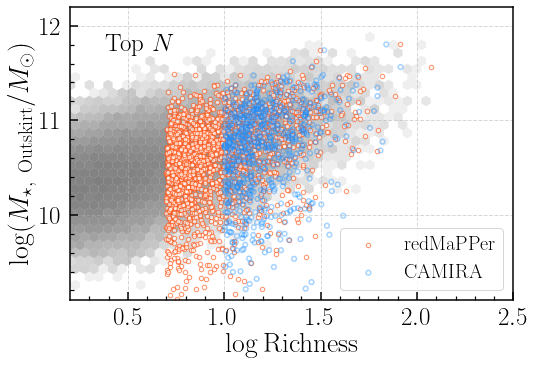

In [63]:
fig = plt.figure(figsize=(7, 5.5))

fig.subplots_adjust(
    left=0.11, bottom=0.15, right=0.99, top=0.89, wspace=0.35, hspace=0.1)

ax1 = fig.add_subplot(111)

# M100 v.s. M10 plane
hbin = ax1.hexbin(mock['richness'], mock['mout'], gridsize=(60, 20), bins='log', cmap='gray_r', 
                  mincnt=1, edgecolor='none', alpha=0.5)

ax1.scatter(
    np.log10(hsc_new[red_flag]['lambda_redm_hsc']), hsc_new[red_flag]['logm_50_150'], 
    s=20, alpha=0.6, facecolor='w', edgecolor='orangered', label=r'$\rm redMaPPer$')

ax1.scatter(
    np.log10(hsc_new[cam_flag]['n_mem_cam']), hsc_new[cam_flag]['logm_50_150'], 
    s=22, alpha=0.4, facecolor='none', edgecolor='dodgerblue', label=r'$\rm CAMIRA$',
    linewidth=1.5)

ax1.legend(loc='lower right', fontsize=20)

ax1.set_xlim(0.2, 2.5)
ax1.set_ylim(9.1, 12.2)
_ = ax1.set_xlabel(r"$\log \rm Richness$", fontsize=28)
_ = ax1.set_ylabel(r"$\log (M_{\star,\ \rm Outskirt}/M_{\odot})$", fontsize=28)

_ = ax1.text(0.08, 0.85, r"${\rm Top}\ N$", fontsize=25, transform=ax1.transAxes)

In [64]:
mock.sort('richness')
mock.reverse()
sample_1 = copy.deepcopy(mock[0: 2000])
limit_1 = mock['richness'][2000]

In [65]:
mock.sort('mout')
mock.reverse()
sample_2 = copy.deepcopy(mock[0: 2000])
limit_2 = mock['mout'][2000]

In [69]:
topn_redm_1 = topn_cluster['redm_hsc_lambda']
topn_mout_1 = topn_massive['logm_50_100']

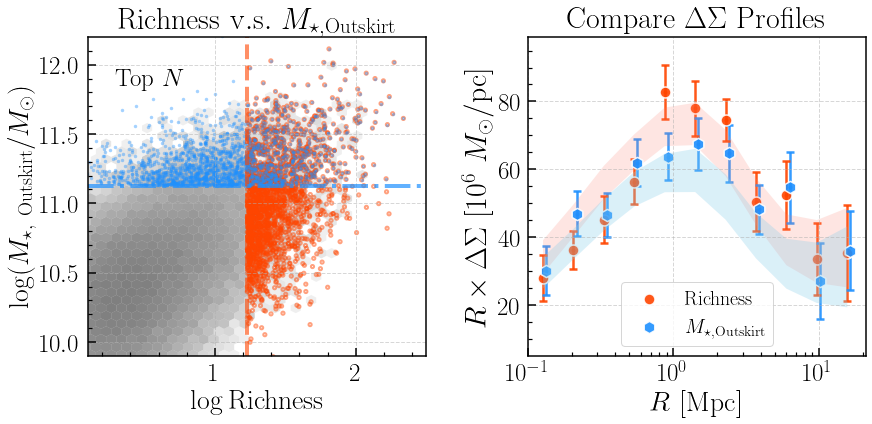

In [72]:
fig = plt.figure(figsize=(12, 5.4))

fig.subplots_adjust(
    left=0.09, bottom=0.16, right=0.99, top=0.98, wspace=0.3, hspace=0.1)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# M100 v.s. M10 plane
hbin = ax1.hexbin(mock['richness'], mock['mout'], gridsize=(40, 30), bins='log', cmap='gray_r', 
                  mincnt=1, edgecolor='none', alpha=0.5)

ax1.axvline(limit_1, linewidth=4, linestyle='--', color='orangered', alpha=0.6)
ax1.axhline(limit_2, linewidth=4, linestyle='-.', color='dodgerblue', alpha=0.7)

ax1.scatter(sample_1['richness'], sample_1['mout'], s=10, facecolor='none', edgecolor='orangered',
            linewidth=2, alpha=0.5)

ax1.scatter(sample_2['richness'], sample_2['mout'], s=12, facecolor='dodgerblue', edgecolor='w',
            linewidth=0, alpha=0.4)

ax1.set_xlim(0.1, 2.5)
ax1.set_ylim(9.9, 12.2)
_ = ax1.set_xlabel(r"$\log \rm Richness$", fontsize=28)
_ = ax1.set_ylabel(r"$\log (M_{\star,\ \rm Outskirt}/M_{\odot})$", fontsize=28)


_ = ax1.text(0.08, 0.85, r"${\rm Top}\ N$", fontsize=25, transform=ax1.transAxes)


ax2.set_xscale("log", nonpositive='clip')

ax2.errorbar(
    topn_redm_1.meta['r_mpc'], 
    topn_redm_1.meta['r_mpc'] * topn_redm_1[0]['dsigma'], 
    yerr=(topn_redm_1.meta['r_mpc'] * topn_redm_1[0]['dsig_err_jk']),
    ecolor='orangered', color='orangered', alpha=0.9, capsize=4, 
    capthick=2.5, elinewidth=2.5, label='__no_label__', fmt='.', zorder=0)

ax2.scatter(
    topn_redm_1.meta['r_mpc'],
    topn_redm_1.meta['r_mpc'] * topn_redm_1[0]['dsigma'], 
    s=120, alpha=0.9, facecolor='orangered', edgecolor='w', marker='o', 
    linewidth=1.5, label=r'$\rm Richness$')

# Best-fit profile
sum_bin = topn_redm_1[0]
cov_type = 'jk'
err_low = sum_bin['dsigma_mod_' + cov_type] - sum_bin['dsigma_mod_low_' + cov_type]
err_upp = sum_bin['dsigma_mod_upp_' + cov_type] - sum_bin['dsigma_mod_' + cov_type]
ax2.fill_between(
    topn_redm_1.meta['r_mpc'], 
    topn_redm_1.meta['r_mpc'] * (sum_bin['dsigma_mod_' + cov_type] - err_low * 5),
    topn_redm_1.meta['r_mpc'] * (sum_bin['dsigma_mod_' + cov_type] + err_low * 5),
    alpha=0.2, edgecolor='none', linewidth=1.0,
    facecolor='salmon', linestyle='--', rasterized=True)

ax2.errorbar(
    topn_mout_1.meta['r_mpc'] * 1.05, 
    topn_mout_1.meta['r_mpc'] * 1.05 * topn_mout_1[0]['dsigma'], 
    yerr=(topn_mout_1.meta['r_mpc'] * topn_mout_1[0]['dsig_err_jk']),
    ecolor='dodgerblue', color='dodgerblue', alpha=0.9, capsize=4, 
    capthick=2.5, elinewidth=2.5, label='__no_label__', fmt='.', zorder=0)

ax2.scatter(
    topn_mout_1.meta['r_mpc'] * 1.05,
    topn_mout_1.meta['r_mpc'] * 1.05 * topn_mout_1[0]['dsigma'], 
    s=150, alpha=0.9, facecolor='dodgerblue', edgecolor='w', marker='h', 
    linewidth=1.5, label=r'$M_{\star,\rm Outskirt}$')

# Best-fit profile
sum_bin = topn_mout_1[0]
cov_type = 'jk'
err_low = sum_bin['dsigma_mod_' + cov_type] - sum_bin['dsigma_mod_low_' + cov_type]
err_upp = sum_bin['dsigma_mod_upp_' + cov_type] - sum_bin['dsigma_mod_' + cov_type]
ax2.fill_between(
    topn_mout_1.meta['r_mpc'], 
    topn_mout_1.meta['r_mpc'] * (sum_bin['dsigma_mod_' + cov_type] - err_low * 5),
    topn_mout_1.meta['r_mpc'] * (sum_bin['dsigma_mod_' + cov_type] + err_low * 5),
    alpha=0.3, edgecolor='none', linewidth=1.0,
    facecolor='skyblue', linestyle='--', rasterized=True)

ax2.set_ylim(5, 99)

ax2.legend(loc='lower center', fontsize=20)

_ = ax2.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=28)
_ = ax2.set_ylabel(r'$R \times \Delta\Sigma\ [10^{6}\ M_{\odot}/\mathrm{pc}]$', fontsize=30)

_ = ax1.set_title(r"${\rm Richness\ v.s.}\ M_{\star, \rm Outskirt}$", fontsize=30)
_ = ax2.set_title(r"${\rm Compare}\ \Delta\Sigma\ {\rm Profiles}$", fontsize=30)

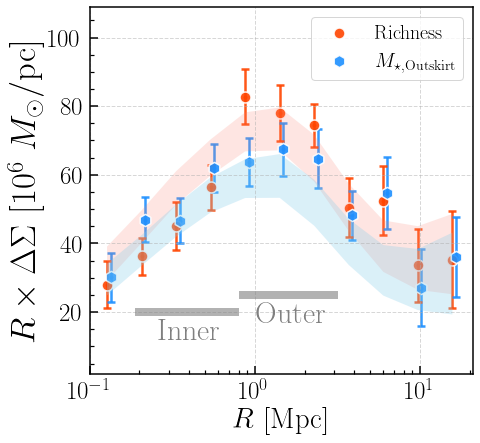

In [74]:
fig = plt.figure(figsize=(6.5, 6))
fig.subplots_adjust(
    left=0.17, bottom=0.14, right=0.99, top=0.99, wspace=None, hspace=None)
ax = fig.add_subplot(111)

ax.set_xscale("log", nonpositive='clip')

ax.errorbar(
    topn_redm_1.meta['r_mpc'], 
    topn_redm_1.meta['r_mpc'] * topn_redm_1[0]['dsigma'], 
    yerr=(topn_redm_1.meta['r_mpc'] * topn_redm_1[0]['dsig_err_jk']),
    ecolor='orangered', color='orangered', alpha=0.9, capsize=4, 
    capthick=2.5, elinewidth=2.5, label='__no_label__', fmt='.', zorder=0)

ax.scatter(
    topn_redm_1.meta['r_mpc'],
    topn_redm_1.meta['r_mpc'] * topn_redm_1[0]['dsigma'], 
    s=120, alpha=0.9, facecolor='orangered', edgecolor='w', marker='o', 
    linewidth=1.5, label=r'$\rm Richness$')

# Best-fit profile
sum_bin = topn_redm_1[0]
cov_type = 'jk'
err_low = sum_bin['dsigma_mod_' + cov_type] - sum_bin['dsigma_mod_low_' + cov_type]
err_upp = sum_bin['dsigma_mod_upp_' + cov_type] - sum_bin['dsigma_mod_' + cov_type]
ax.fill_between(
    topn_redm_1.meta['r_mpc'], 
    topn_redm_1.meta['r_mpc'] * (sum_bin['dsigma_mod_' + cov_type] - err_low * 5),
    topn_redm_1.meta['r_mpc'] * (sum_bin['dsigma_mod_' + cov_type] + err_low * 5),
    alpha=0.2, edgecolor='none', linewidth=1.0,
    facecolor='salmon', linestyle='--', rasterized=True)

ax.errorbar(
    topn_mout_1.meta['r_mpc'] * 1.05, 
    topn_mout_1.meta['r_mpc'] * 1.05 * topn_mout_1[0]['dsigma'], 
    yerr=(topn_mout_1.meta['r_mpc'] * topn_mout_1[0]['dsig_err_jk']),
    ecolor='dodgerblue', color='dodgerblue', alpha=0.9, capsize=4, 
    capthick=2.5, elinewidth=2.5, label='__no_label__', fmt='.', zorder=0)

ax.scatter(
    topn_mout_1.meta['r_mpc'] * 1.05,
    topn_mout_1.meta['r_mpc'] * 1.05 * topn_mout_1[0]['dsigma'], 
    s=150, alpha=0.9, facecolor='dodgerblue', edgecolor='w', marker='h', 
    linewidth=1.5, label=r'$M_{\star,\rm Outskirt}$')

# Best-fit profile
sum_bin = topn_mout_1[0]
cov_type = 'jk'
err_low = sum_bin['dsigma_mod_' + cov_type] - sum_bin['dsigma_mod_low_' + cov_type]
err_upp = sum_bin['dsigma_mod_upp_' + cov_type] - sum_bin['dsigma_mod_' + cov_type]
ax.fill_between(
    topn_mout_1.meta['r_mpc'], 
    topn_mout_1.meta['r_mpc'] * (sum_bin['dsigma_mod_' + cov_type] - err_low * 5),
    topn_mout_1.meta['r_mpc'] * (sum_bin['dsigma_mod_' + cov_type] + err_low * 5),
    alpha=0.3, edgecolor='none', linewidth=1.0,
    facecolor='skyblue', linestyle='--', rasterized=True)

ax.set_ylim(2, 109)

ax.legend(loc='upper right', fontsize=20)

ax.plot([0.2, 0.76], [20, 20], linewidth=8, color='grey', alpha=0.6)
ax.plot([0.85, 3.0], [25, 25], linewidth=8, color='grey', alpha=0.6)

ax.text(0.26, 12, r'$\rm Inner$', fontsize=30, color='grey')
ax.text(1.02, 17, r'$\rm Outer$', fontsize=30, color='grey')

_ = ax.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=29)
_ = ax.set_ylabel(r'$R \times \Delta\Sigma\ [10^{6}\ M_{\odot}/\mathrm{pc}]$', fontsize=35)